# Image classificator based on ResNet and TinyImageNet

**Author:** Vincenzo Barbato

**Place:** University of Parma

**Date:** 2024


## Introduction

### TinyImageNet

TinyImagenet, a dataset of 200 classes derived from ImageNet, contains 100,000 images as a training set (500 per each class), 10,000 as a validation set, and 10,000 as a test set (50 per each class). The training set and validation set are labeled, while the test set is not.

### ResNet

ResNet, short for Residual Network, is a deep neural network architecture that tackles the training problem by introducing residual connections.
The key idea of ResNet is the utilization of residual blocks, which are building blocks containing skip connections (also known as shortcut connections) to bypass certain layers. These skip connections enable gradients to flow more easily during training, mitigating the issue of vanishing gradients that typically occurs in very deep networks. Consequently, ResNet can effectively train networks with hundreds or even thousands of layers.
A typical residual block consists of two main paths: the identity path and the residual path. The identity path simply forwards the input directly to the output without any alteration. The residual path applies a series of transformations (usually including convolutional layers and activation functions) to the input. The output of the residual block is obtained by adding the input to the output of the residual path. Mathematically, this can be represented as:

<div align="center">
  Output = Input + Residual(Input) 
</div>

This formulation allows the model to learn the residual, or the difference between the desired output and the input, making it easier to optimize the weights of the residual path.

<center>
<img src="../assets/images/resNet_architectures.png" >
</br>
Fig. 1
</center>


## Project assigment

### Description

Train a model to classify all the images and make some ablation studies you prefer.

In addition, add one ablation study to evaluate how performance vary if the number of classes during the training are 1 or 10 (the last 9 are randomly or carefully selected):

Step (a):

1. choose one class "A" (the one you prefer)
2. train from scratch the model with only the images related to that class "A" you chosen
3. collect info about classification performance (of class "A")

Step (b):

4. choose randomly 9 classes
5. train from scratch the model with the images of class "A" + images of the 9 classes
6. collect info about classification performance (of class "A" and of all 10 classes chosen)
7. repeat points 4,5,6 at least 3 times

Step (c):

8. choose the 9 classes you think most resemble class "A"
9. repeat points 5,6

How the classification performance of class "A" changed?

Could you drawn some conclusions? (e.g. it is better to train the model only with the images of class "A" or not? There are some differences on performance depending of which additional classes you use? …)

### First consideration

To train model to obtain best performance (in term of time and accuracy) we need to consider different aspect.

- The first one is resNet type, residual network with more layers, can classify better the classes of dataset, but need more time. Different type of resNet can need different hyper-parameters configuration. Another aspect is choose a pretrained or not-pretrained network.

- The second one is dataset and batch size. Dataset with more images can give better performance but need time to train (in accord with batch size).

- The third one are optimizer and learning rate. We focus on SGD and Adam optimizer (the more used).

- The fourth one are hyper-parameters for generalization. We can need to apply dropout on residual block and final layer. We can need weight decay (L2 regularization, default assignable for Adam and SGD optimizer).


## Dataset

### Augmentation

As already mentioned the test set is not labeled, because we use validation set like test set and split train set in train and validation set (20% of train set became validation set).
Therefore for one class we have 450 images for train set, 50 images for validation set and 50 images for test set.

Is possible apply data augmentation to the train set (only the train set because is better that validation and test set are original images).
As the tinyImageNet derived from ImageNet we use ImageNet data augmentation.

Transform example:

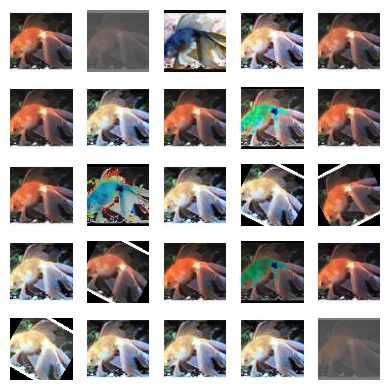

In [14]:
# Run to se data augmentation in action
from pathlib import Path


import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tinyimagenet import TinyImageNet



test = TinyImageNet(
    Path("~/.torchvision/tinyimagenet/"),
    split="val",
    imagenet_idx=False,
    transform=transforms.RandomHorizontalFlip(p=0),
)



policy = transforms.AutoAugmentPolicy.IMAGENET
augmenter = transforms.AutoAugment(policy)
transform = transforms.Compose(
    [
        augmenter,

    ]
)



newset = []


newset.append(test[0][0])



for i in range(24):


    newset.append(transform(test[0][0]))



fig, axes = plt.subplots(5, 5, figsize=(4, 4))



for i, ax in enumerate(axes.flat):
    ax.imshow(newset[i])
    ax.axis("off")



plt.tight_layout()
plt.show()

<center>
Best results out of 5 </br>

| Train Set    | Data Augmentation | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time  |
| ------------ | ----------------- | --------- | -------- | --------- | ------ | --------- | -------------- |
| 4500 images  | Not Applied       | 1.192     | 0.622    | 0.628     | 0.622  | 0.633     | 35.605 seconds |
| 27000 images | Applied           | 1.112     | 0.660    | 0.663     | 0.660  | 0.666     | 1.500 minutes  |

Table 1 </br>
NP-ResNet18, batch size 32, learning rate 0.001, momentum 0.9, dropout 0, weight decay 0.0 </br>
Tested on 10 classes

Data augmentation helps to improve model performances and generalization. Obviously it will be used in accord with other parameters and computer memory.

</center>


### Classes for test

The classes randomly selected that we use for test are:


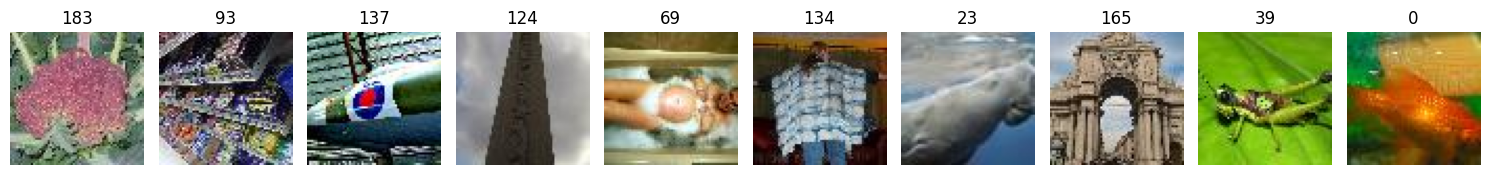

In [15]:
# Run to see the 10 test classes
import numpy as np

classes = [183, 93, 137, 124, 69, 134, 23, 165, 39, 0]
newset = []
plus = np.random.randint(0, 50)
for i in classes:
    newset.append(test[i * 50 + plus][0])

for i in range(24):
    newset.append(transform(test[0][0]))

fig, axes = plt.subplots(1, 10, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow(newset[i])
    ax.axis("off")
    ax.set_title(classes[i])

plt.tight_layout()
plt.show()

## Residual Network

### Resnet block

For the studies we choose resNet18, for its simplicity and shorter training time compared to other residual networks, and resNet50 to observe the difference with deeper networks.

The model is load from Pytorch Hub, it is a pre-trained model repository designed to facilitate research reproducibility. Is possible load pre-trained or not pre-trained model.

The possible block of resNet18 and resNet50 are BasicBlock or Bottleneck:

<center>
<table>
<tr>
    <th>BasicBlock</th>
    <th>Bottleneck</th>
</tr>
<tr>
    <td style="vertical-align: top;">
<pre>

    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

</pre>
    </td>
    <td style="vertical-align: top;">
<pre>

    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

</pre>
    </td>
</tr>
</table>

Table 2</br>

</center>


### Dropout

Dropout is a regularization technique used in neural networks to prevent overfitting. It works by randomly deactivating (setting to zero) a fraction of neurons during training, which forces the network to learn redundant representations and prevents it from relying too much on specific neurons. This encourages the network to generalize better to unseen data.
Dropout is applied independently to each neuron, so different neurons are dropped out at each iteration.

The basic idea of dropout on residual block is that too dropout can block the learning of important features because the dropout of residual block is less that dropout on fc layers.

In this study we analyze the result of different dropout position in the residual block and in the head of resNet (Different network configuration available to [link](../notes/network.ipynb)).

The common use say to apply dropout after each ReLU. The difference of apply dropout before or after ReLU are insignificant. Dropout and ReLU are a permutable oprerations because [1]:

<center>ReLU(Dropout(x)) = Dropout(ReLU(x)) </center>

<center>
</br>
Best results out of 5 </br>

| Experiment          | Early Stop Epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time (minutes) |
| ------------------- | ---------------- | --------- | -------- | --------- | ------ | --------- | ----------------------- |
| Dropout before ReLU | 10               | 0.851     | 0.738    | 0.737     | 0.738  | 0.737     | 4.954                   |
| Dropout after ReLU  | 11               | 0.796     | 0.754    | 0.752     | 0.754  | 0.751     | 5.461                   |

Table 3 </br>
NP-ResNet18, batch size 16, learning rate 0.001, momentum 0.9, dropout\_ rb 0.1, dropout_fc 0.0, weight decay 0.0 </br>
Tested on 10 classes (27000 samples with data augmentation)

</center>

This solution work good, but the control on dropout rate is small, especially if we want compare different network. The reason is that this solution apply dropout after or before each ReLU. Therefore if we consider basic block we have applied dropout to 2 ReLU layers, but if we consider bottleneck we have applied dropout to 3 ReLU layers (see table 2).


For this reasons we apply dropout, for each residual block, after the last ReLU before the identity[1]:

<center>
Best results out of 5 </br>

| Experiment                          | Early Stop Epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time (minutes) |
| ----------------------------------- | ---------------- | --------- | -------- | --------- | ------ | --------- | ----------------------- |
| One dropout for each residual block | 9                | 0.849     | 0.748    | 0.749     | 0.748  | 0.750     | 3.721                   |

Table 4 </br>
NP-ResNet18, batch size 16, learning rate 0.001, momentum 0.9, dropout_rb 0.4, dropout_fc 0.0, weight decay 0.0 </br>
Tested on 10 classes (27000 samples with data augmentation) </br>
</br>

Average on 5 results </br>
| Experiment | Average Epochs | Average Test Loss | Average Accuracy | Average F-Measure | Average Recall | Average Precision | Average Training Time (minutes) |
|------------|----------------|-------------------|------------------|-------------------|----------------|-------------------|--------------------------------|
| One dropout for each residual block | 10 | 0.861 | 0.730 | 0.730 | 0.730 | 0.731 | 4.3018 |
| Dropout after ReLU | 10.4 | 0.852 | 0.727 | 0.726 | 0.727 | 0.726 | 4.9976 |

Table 5 </br>

<div style="display: flex; justify-content: space-around; align-items: center;">
    <figure>
        <img src="../assets/images/one dropout-for-each-residual-block.jpg" alt="One dropout for each residual block" style="width: 400px;"/>
        <figcaption>Fig.2 - One dropout for each residual block</figcaption>
    </figure>
    <figure>
        <img src="../assets/images/dropout-after-each-relu.jpg" alt="Dropout after each ReLU" style="width: 400px;"/>
        <figcaption>Fig.3 - Dropout after each ReLU</figcaption>
    </figure>
</div>
</center>


In the same way we check the best position for dropout in the head. ResNet head is a simple sequence of AdaptiveAvgPool and linear layer that have as input the output of AdaptiveAvgPool and as output the number of classes that we want to classify.

Because the two possible position of dropout layer are before or after the AdaptiveAvgPool[1].

<center>
Best results out of 5 </br>

| Experiment                     | Early Stop Epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time (minutes) |
| ------------------------------ | ---------------- | --------- | -------- | --------- | ------ | --------- | ----------------------- |
| Dropout before AdaptiveAvgPool | 17               | 0.751     | 0.762    | 0.762     | 0.762  | 0.761     | 7.212                   |
| Dropout after AdaptiveAvgPool  | 20               | 0.725     | 0.758    | 0.753     | 0.758  | 0.749     | 9.085                   |

Table 6 </br>
NP-ResNet18, batch size 16, learning rate 0.001, momentum 0.9, dropout\_ rb 0.5, dropout_fc 0.5, weight decay 0.0 </br>
Tested on 10 classes (27000 samples with data augmentation) </br>
